In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# importing necessary libraries
from io import open
import glob
import os
import unicodedata
import string
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
# using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# ensuring reproducibility of code
torch.manual_seed(0)
np.random.seed(0)

# Preparing the Data

In [ ]:
findfiles = glob.glob('/content/gdrive/My Drive/Deep Learning/pytorch-experiments/NLP/data/names/*.txt')
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [ ]:
def unicode_to_ascii(s):
    """
    turns a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [ ]:
def read_lines(filename):
    """
    reads a file and splits it into lines.
    """
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

In [ ]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

for filename in findfiles:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [ ]:
def letter_to_index(letter):
    """
    returns index of letter in the alphabet.
    """
    return all_letters.find(letter)

In [ ]:
def letter_to_tensor(letter):
    """
    turn a letter to a (1 x n_letters) tensor.
    """
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [ ]:
def line_to_tensor(line):
    """
    turn a line into an array of one-hot letter vectors.
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


# The Network

In [ ]:
class charRNN(nn.Module):
    """
    returns a simple character level RNN.
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(charRNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
  
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
n_hidden = 128
rnn = charRNN(n_letters, n_hidden, n_categories)

## Helper functions

In [ ]:
def category_from_output(output, all_categories):
    """
    returns most likely category from output of the network.
    """
    _, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [ ]:
def random_choice(l):
    """
    returns a random choice from a given collection.
    """
    return l[random.randint(0, len(l) - 1)]

def random_training_example(all_categories):
    """
    returns a random training example.
    """
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example(all_categories)
    print('category =', category, '/ line =', line)

category = German / line = Kurzmann
category = Dutch / line = Reynder
category = Arabic / line = Abadi
category = French / line = Duval
category = French / line = Vipond
category = Spanish / line = Crespo
category = Irish / line = Ruaidh
category = Chinese / line = Fung
category = Arabic / line = Shadid
category = French / line = Allard


## Training

In [ ]:
def train(category_tensor, line_tensor):
    """
    one forward + backward pass through the RNN.
    """
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    # forward pass
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # update parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

    return output, loss.item()

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 1e-3
n_iterations = 500000
print_iter_gap = 50000
plot_iter_gap = 10000

In [ ]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

# iterating over the dataset
for iter in range(1, n_iterations + 1):
    category, line, category_tensor, line_tensor = random_training_example(all_categories)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_iter_gap == 0:
        guess, guess_i = category_from_output(output, all_categories)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d%% loss = %.4f \n %s / %s %s' % 
              (iter / n_iterations * 100, loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_iter_gap == 0:
        all_losses.append(current_loss / plot_iter_gap)
        current_loss = 0

10% loss = 2.2404 
 Saionji / Italian ✗ (Japanese)
20% loss = 1.2699 
 Koiso / Japanese ✓
30% loss = 0.0302 
 Sasakawa / Japanese ✓
40% loss = 0.5077 
 So / Korean ✓
50% loss = 0.2993 
 Mckay / Scottish ✓
60% loss = 4.6149 
 Samuel / Arabic ✗ (Irish)
70% loss = 0.9898 
 Khu / Chinese ✓
80% loss = 2.5142 
 Parish / French ✗ (English)
90% loss = 1.4154 
 Costa / Portuguese ✓
100% loss = 0.7430 
 Lawniczak / Polish ✓


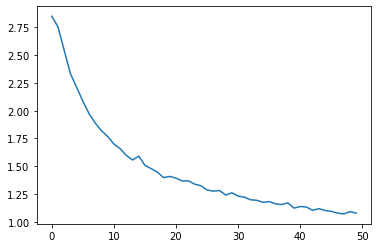

In [ ]:
plt.figure()
plt.plot(all_losses)

# Evaluating

In [ ]:
def evaluate(line_tensor):
    """
    return an output given an input.
    """
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Ostrovsky')
predict('Jackson')
predict('Satoshi')


> Ostrovsky
(-0.47) Russian
(-1.17) Czech
(-3.61) English

> Jackson
(-0.45) Scottish
(-1.58) English
(-2.14) Russian

> Satoshi
(-0.58) Japanese
(-1.78) Arabic
(-2.02) Italian
